<a href="https://colab.research.google.com/github/kekys778/avito_ds_2025/blob/main/model_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***ЗАДАЧА, ОПИСАНИЕ, РЕШЕНИЕ***
Требовалось придумать метод, который бы помогал эффективно справляться с ситцациями, когда пользователи пропускали пробелы между словами, что снижает эффективность поиска ТиУ на авито.
# **Требования бизнеса**

*   Справляться со своей задачей эффективно ( учитывать то, как люди пишут объявления и ищут их, полиязычной, выделять и также обрабатывать несловарные слова)
*   Легковескной, так как должа инферинситься в реал тайме
*   Энергоэффективной, так как издержки на инференс могут стоить дороже, если например это LLM

# **Ход решения**
*   **Формализация задачи:** Необходимо разработать модель, которая бы сегментировала бы слова и ставила токен пробела.
Сведем задачу к сегментации, при которой модель выдает вероятность пробела после токена.
*   **Исследование подходов:**  Очевидно, что такая задача существует уже достаточно давно и было придумано множество решений от алгоритмичных и словарных (в ворде, например), то мльных и малоэффективных (запрячь ллмку).
Мной был выбран подход описанный в статье `Fast Whitespace Correction with Encoder-Only Transformers`, в которой для этой задачи использовалась encoder-only model и даже с большими последовательностями выдавала очень высокий результат. Посокльку решение показалось эффективным в определенных моментах, я решил использовать архитектурные особенности, а тажке подходы к обучению, которые были представленны в статье.
*    **Преимущества и особенности подхода:**
        *     работает на байтовом уровне, а значит не привязана к ошибкам в орфографии, языка, словаря
        *     благодаря тому, что это дл-подход, легко масштабируется
        *     эффективность модели: модель очень хорошо справляется с задачей даже при обучении не на доменной области (об этом позже), с зашумленными данными
*    **Недостатки:**
        *     схожее и даже лучшее качество до определенного момента можно получать вероятностными моделями
        *     скорость все-таки нижу, возможно, для работы с большими данными необходимы будут мощности GPU
        *     длина последовательности
Очевидно, что такие недостатки для бизнеса не являются существенными, так как при аккамилировании большого количества данных, dl подходы чаще всего эффективнее. Также так как длина последовательности не неограниченна, то модель можно эффективно научить смотреть на максимальную допустимую длину.

# **Архитектура верхнеуровненво**
*   **В качестве базовой модели был выбран encoder-only Transformer, на основе того, что указан в статье**
      *   encoder-only модели существенно легче и быстрее в инференсе, чем enc-dec или LLM. Для real-time применения это критично.
      *   Датасет отзывов, описаний товаров с WB. - файнтьюнинг
          - доменнные данные с менее агрессивной предобработкой
          -  5 млн строк,
          -  1 эпоха,
          -  время обучения: 6 часов
          -  ресурсы: GPU T4 (Kaggle)
# **Архитектура подробнее**
*   Вход: последовательность байтов (длина до 512).
*   Embedding слой: каждый байт переводится в вектор фиксированной размерности.
*   Позиционные эмбеддинги: добавляются для учёта порядка символов.
*   6 слоёв Transformer-encoder:
    -  многоголовое внимание (6 голов)
    -  нормализация и feed-forward блоки.
*   Выходной классификатор: линейный слой с softmax, который предсказывает для каждого байта вероятность двух классов:
    -  0 — пробел не нужен
    -  1 — пробел нужно вставить


# **Обучение**
*   **Данные:**
      *   Дамп Википедии на русском.
          - качественные очищенные тексты,
          -  15 млн строк,
          -  2 эпохи,
          -  время обучения: 12 часов
          -  ресурсы: GPU T4 (Kaggle)
      *   Датасет отзывов, описаний товаров с WB. - файнтьюнинг
          - доменнные данные с менее агрессивной предобработкой
          -  5 млн строк,
          -  1 эпоха,
          -  время обучения: 6 часов
          -  ресурсы: GPU T4 (Kaggle)

# **ИТОГ**
*   Архитектура: **encoder-only Transformer**, работающий на байтовом уровне.
*   Размер: **всего 84 МБ (7 млн параметров)**.
*   Качестьво:
    -   на обучающем датасете — **F1 > 96%**,
    -   на тестовом датасете  — **F1 > 96%**,
    -   в тестовом задании — **F1 > 94%**,
*   Инференс: **быстрый, подходит для real-time обработки на CPU**, но также **масштабируется** на GPU

# **PS: а как улучшить**
*   **domain-shift**: из-за не совсем доменных текстов, модель с трудом распознает личн.месторимения, глаголы 1 лица (они встречаются чаще в объявлениях, чем в вики и описании товаров). Соответственно, имеет смысл сразу обучать на нашем домене (к сожалению, у меня такого не было во время обучения, чуть позже обнаружил, что есть тексты, которые ближе к задаче)
*   **Увеличить окно контекста + сложность архитепктры**. Да это потребует больше времени на ф1 поднимится не так высоко, думаю, добьет до 97-98, но это того стоит.


ЗЫ2:) Спасибо, что глянули мою работу, я старался)

In [1]:
import math
import pandas as pd
import random
import re
import torch
import torch.nn as nn
import torch.optim as optim
import unicodedata


from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import List, Tuple, Dict

In [2]:
PAD_ID = 256
VOCAB_SIZE = 257

class RussianByteTokenizer:
    def __init__(self, pad_id=PAD_ID):
        self.pad_id = pad_id
        self._vocab_size = VOCAB_SIZE

    def encode(self, text: str, max_length=384, truncation=True):
        text = unicodedata.normalize('NFKC', text) #нормализуем Юникод
        b = text.encode("utf-8") #переводим в байты
        if truncation:
            b = b[:max_length]
        ids = list(b)
        if len(ids) < max_length:
            ids += [self.pad_id] * (max_length - len(ids))
        return ids

    def decode(self, ids):
        valid = [i for i in ids if i != self.pad_id]
        return bytes(valid).decode("utf-8", errors="ignore")

    def pad_token_id(self):
        return self.pad_id

    def vocab_size(self):
        return self._vocab_size

In [3]:
class SpaceInsertionModel(nn.Module):
    """Модель выдает вероятность пробела после каждого символа"""
    def __init__(self, vocab_size: int = 257, hidden_dim: int = 384,
                 num_layers: int = 6, num_heads: int = 6):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.byte_embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=PAD_ID)
        self.pos_embedding = nn.Embedding(512, hidden_dim)

        # энкодер на трансформере (EO-архитектура)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 2,
            dropout=0.1,
            batch_first=True,
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # последний слой: классфикатор выдает вероятность пробела
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, 2)
        )
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        batch_size, seq_len = x.shape

        # Embeddings
        token_emb = self.byte_embedding(x)
        pos_ids = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        pos_emb = self.pos_embedding(pos_ids)

        emb = token_emb + pos_emb
        emb = self.dropout(emb)

        padding_mask = (x == PAD_ID)

        encoded = self.encoder(emb, src_key_padding_mask=padding_mask)

        logits = self.classifier(encoded)  # (batch, seq, 2)

        return logits

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RussianByteTokenizer()
model = SpaceInsertionModel(
        vocab_size=tokenizer.vocab_size(),
        hidden_dim=384,
        num_layers=6,
        num_heads=6
    ).to(device)

In [5]:
#загружаем актуальный чекпонт модели. Пайплайн обучения, информация о данных и обработке в read.me, а также код в тетрадке training
!gdown https://drive.google.com/uc?id=1ZBW8OdNov0rCs_U1KscmDTKNTUtID4HN


checkpoint_path = '/content/checkpoint_epoch_1_batch_35000.pth'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

Downloading...
From (original): https://drive.google.com/uc?id=1ZBW8OdNov0rCs_U1KscmDTKNTUtID4HN
From (redirected): https://drive.google.com/uc?id=1ZBW8OdNov0rCs_U1KscmDTKNTUtID4HN&confirm=t&uuid=dae3ad00-9b39-430c-bcb8-39845e55a570
To: /content/checkpoint_epoch_1_batch_35000.pth
100% 88.9M/88.9M [00:00<00:00, 118MB/s]


In [6]:
if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("Модель готова инференсить")

Модель готова инференсить


In [7]:
def get_space_positions(text_with_spaces: str) -> list[int]:

    # Удаляем все пробелы
    text_without_spaces = text_with_spaces.replace(' ', '')

    space_positions = []
    current_index_in_original = 0

    for i, char in enumerate(text_with_spaces[:-1]):
        if char == ' ':
            space_positions.append(current_index_in_original)
        else:
            current_index_in_original += 1

    return space_positions

def f1_score_positions(true_pos, pred_pos) -> float:
    """ф1 для одной строки"""
    true_set, pred_set = set(true_pos), set(pred_pos)
    if not true_set and not pred_set:
        return 1.0
    if not pred_set:
        return 0.0

    tp = len(true_set & pred_set)
    precision = tp / len(pred_set) if pred_set else 0
    recall = tp / len(true_set) if true_set else 0

    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

def corrupt_for_test(text: str) -> str:

    if " " not in text:
        return text

    r = random.random()

    if r < 0.5:  # 50%
        return text.replace(" ", "")
    elif r < 0.8:  # 30%
        words = text.split()
        new_text = words[0]
        for w in words[1:]:
            if random.random() < random.uniform(0.3, 0.7):
                new_text += w
            else:
                new_text += " " + w
        return new_text
    else:  # 20%
        space_indices = [i for i, c in enumerate(text) if c == " "]
        if not space_indices:
            return text
        idx = random.choice(space_indices)
        return text[:idx] + text[idx+1:]

def insert_spaces_with_positions(model, text: str, tokenizer, device, threshold=0.3, augment=False):
    """Восстановление пробелов"""
    model.eval()

    corrupted_text = corrupt_for_test(text) if augment else text.replace(" ", "")

    input_ids = tokenizer.encode(corrupted_text, max_length=384)
    input_tensor = torch.tensor([input_ids]).to(device)

    with torch.no_grad():
        logits = model(input_tensor)
        probabilities = torch.softmax(logits, dim=-1)
        space_probs = probabilities[0, :, 1]
        predictions = (space_probs > threshold).cpu().numpy()

    # Восстановление текста
    result = ""
    byte_idx = 0
    for char in corrupted_text:
        result += char
        char_bytes = len(char.encode("utf-8"))
        should_add_space = any(
            byte_idx + i < len(predictions) and predictions[byte_idx + i]
            for i in range(char_bytes)
        )
        if should_add_space and result[-1] != " ":
            result += " "
        byte_idx += char_bytes

    # Метки
    true_positions = get_space_positions(text)
    pred_positions = get_space_positions(result)
    f1 = f1_score_positions(true_positions, pred_positions)

    return {
        "original_text": text,
        "corrupted_text": corrupted_text,
        "predicted_text": result,
        "true_positions": true_positions,
        "predicted_positions": pred_positions,
        "f1": f1
    }

def evaluate_on_dataset(model, texts, tokenizer, device, num_samples=5, threshold=0.3, augment=False):
    """запуск модели, вернут датасет"""
    records = []
    for text in texts[:num_samples]:
        rec = insert_spaces_with_positions(model, text, tokenizer, device, threshold=threshold, augment=augment)
        records.append(rec)
    df = pd.DataFrame(records)


    df["predicted_positions"] = df["predicted_positions"].apply(lambda x: str(x))

    mean_f1 = df["f1"].mean()
    print(f"\nMean F1 = {mean_f1:.4f}")
    return df, mean_f1


In [8]:
# !gdown https://drive.google.com/uc?id=1Vcfpgy-qtQVA5HT4fL2O55JH1_Aop3i-
# !unzip /content/full_jokes.txt.zip


Downloading...
From (original): https://drive.google.com/uc?id=1Vcfpgy-qtQVA5HT4fL2O55JH1_Aop3i-
From (redirected): https://drive.google.com/uc?id=1Vcfpgy-qtQVA5HT4fL2O55JH1_Aop3i-&confirm=t&uuid=2aa32c8f-32d4-4b62-b5af-2fee1289ef7b
To: /content/full_jokes.txt.zip
100% 34.4M/34.4M [00:00<00:00, 48.1MB/s]
Archive:  /content/full_jokes.txt.zip
  inflating: full_jokes.txt          


In [9]:
# input_filename = '/content/full_jokes.txt'
# data = []

# data = []
# with open(input_filename, 'r', encoding='utf-8') as txt_file:
#     for line in txt_file:
#         row = line.strip()
#         if row:
#             data.append(row)

In [11]:
# сюда файл для проверки
input_filename = '/content/drive/MyDrive/Colab_Notebooks/Авито/dataset_1937770_3.txt'
task= []

with open(input_filename, 'r', encoding='utf-8') as txt_file:
    lines = txt_file.readlines()
for line in lines[1:]:
    row = line.strip().split(',', 1)
    task.append(row[1])

In [12]:
df, mean_f1 = evaluate_on_dataset(model,task, tokenizer, device, threshold=0.7, num_samples=2000, augment=False)
# чтобы увидеть анекдоты скачать на одну ячейку выше

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(



Mean F1 = 0.9578


In [13]:
# type(df.predicted_positions.iloc[1])
# df['predicted_positions'].reset_index().rename(columns={'index':'id'}).to_csv('perfilev_task.csv',index=False )

In [14]:
df

,original_text,corrupted_text,predicted_text,true_positions,predicted_positions,f1
0,"Только заметил, что слово ""п@рно"" набирается с...","Толькозаметил,чтослово""п@рно""набираетсясамимиц...","Только заметил, что слово ""п@рно"" набирается с...","[6, 14, 17, 22, 29, 39, 45, 57, 67, 70, 73, 83]","[6, 14, 17, 22, 29, 39, 45, 57, 67, 70, 73, 83]",1.000000
1,"Друзья мои, чтобы соответствовать вам, я готов...","Друзьямои,чтобысоответствоватьвам,яготовсделат...","Друзья мои, чтобы соответствовать вам, я готов...","[6, 10, 15, 30, 34, 35, 40, 47, 50, 55, 61, 62...","[6, 10, 15, 30, 34, 35, 40, 47, 50, 55, 61, 62...",1.000000
2,"- Люся, ты все еще хранишь мой подарок?- Да.- ...","-Люся,тывсеещехранишьмойподарок?-Да.-Ядумал,ты...","- Люся, ты все еще хранишь мой подарок?- Да. -...","[1, 6, 8, 11, 14, 21, 24, 33, 37, 38, 44, 46, ...","[1, 6, 8, 11, 14, 21, 24, 33, 36, 37, 38, 44, ...",0.941176
3,"- А вот скажи честно, ты во сне храпишь?- Поня...","-Авотскажичестно,тывоснехрапишь?-Понятиенеимею...","- А вот скажи честно, ты во сне храпишь?- Поня...","[1, 2, 5, 10, 17, 19, 21, 24, 33, 40, 42, 47, ...","[1, 2, 5, 10, 17, 19, 21, 24, 33, 40, 42, 47, ...",0.923077
4,"Поссорилась с мужем. Пока он спал, я мысленно ...","Поссориласьсмужем.Покаонспал,ямысленноразвелас...","Поссорилась с мужем. Пока он спал, я мысленно ...","[11, 12, 18, 22, 24, 29, 30, 38, 47, 48, 52, 6...","[11, 12, 18, 22, 24, 29, 30, 38, 47, 48, 52, 6...",1.000000
...,...,...,...,...,...,...
1995,"- Мойша, вы таки верите в коронавирус?- Конечн...","-Мойша,вытакиверитевкоронавирус?-Конечноверю,я...","- Мойша, вы так и верите в коронавирус?- Конеч...","[1, 7, 9, 13, 19, 20, 33, 40, 45, 46, 48, 51, ...","[1, 7, 9, 12, 13, 19, 20, 33, 40, 45, 46, 48, ...",0.971429
1996,- Где скачать разрешение на работу сварщика?- ...,-Гдескачатьразрешениенаработусварщика?-Разреше...,- Где скачать разрешение на работу сварщика? -...,"[1, 4, 11, 21, 23, 29, 39, 49, 51, 57, 65, 71,...","[1, 4, 11, 21, 23, 29, 38, 39, 49, 51, 57, 65,...",0.969697
1997,"А вы заметили, что под водочку любая закусочка...","Авызаметили,чтоподводочкулюбаязакусочкакажется...","А вы заметили, что под водочку любая за кусочк...","[1, 3, 12, 15, 18, 25, 30, 39, 46]","[1, 3, 12, 15, 18, 25, 30, 32, 39, 46]",0.947368
1998,"- Так, ну и что мы решили?- С чем?- С Новым го...","-Так,нуичтомырешили?-Счем?-СНовымгодом.-Спасиб...","- Так, ну и что мы решили?- С чем? - С Новым г...","[1, 5, 7, 8, 11, 13, 21, 22, 27, 28, 33, 40, 4...","[1, 5, 7, 8, 11, 13, 21, 22, 26, 27, 28, 33, 4...",0.965517


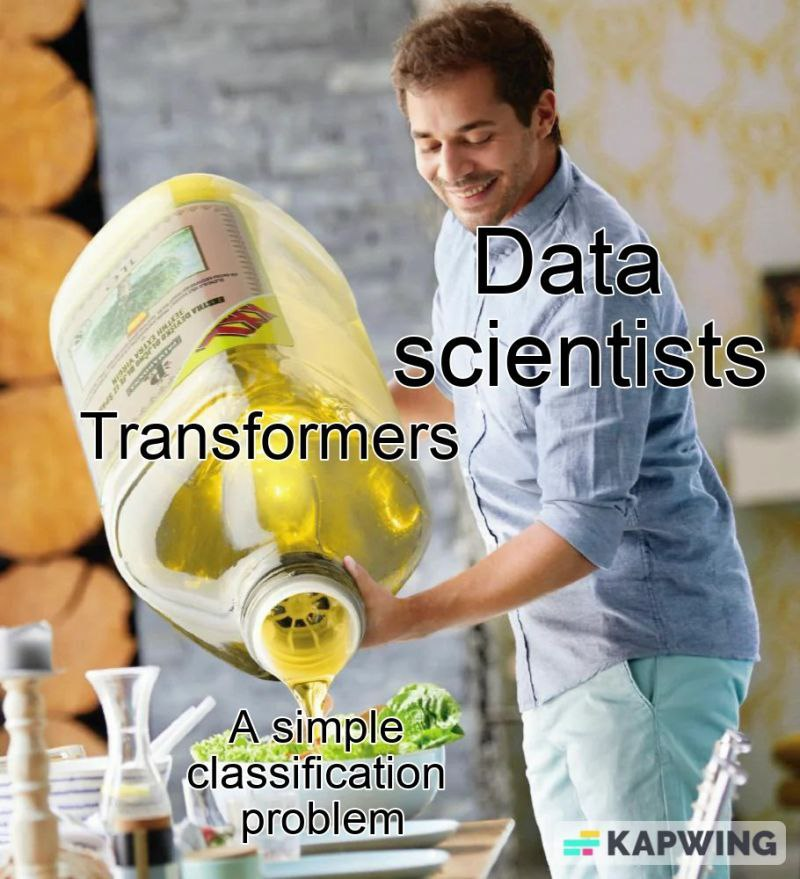